# Random Forest

In [15]:
#Setting up enviroment

!pip -q install shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, RocCurveDisplay

from sklearn.tree import DecisionTreeClassifier

try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("Environment ready. SHAP available:", SHAP_AVAILABLE)

Environment ready. SHAP available: True


In [3]:
# 1) Load data
df = pd.read_csv("wallacecommunications.csv")

# 2) Define target + features
TARGET = "new_contract_this_campaign"

# Drop ID as a unique identifer wouldn't normally be used as a predictor 
drop_cols = ["ID"]
X = df.drop(columns=[TARGET] + [c for c in drop_cols if c in df.columns])
y = df[TARGET]

# If target is "yes/no" strings, convert to 0/1
if y.dtype == "object":
    y = y.str.lower().map({"yes": 1, "no": 0, "y": 1, "n": 0, "true": 1, "false": 0}).astype("int")

In [4]:
# 3) Train / Val / Test split (e.g., 60/20/20)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)  # 0.25 of 0.80 = 0.20

# 4) Identify column types
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

In [5]:
# 5) Preprocessing
# - Numeric: median imputation
# - Categorical: most_frequent imputation + one-hot encoding
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

In [6]:
# 6) Random Forest model
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

# 7) Hyperparameter tuning (RandomizedSearchCV)
param_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [8, 12, 16, 20],
    "model__min_samples_split": [5, 10, 20],
    "model__min_samples_leaf": [4, 8, 16],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5],
    "model__max_samples" : [0.6, 0.8, 1.0],
    "model__bootstrap": [True],
}

In [7]:
from time import perf_counter
import joblib
from joblib import Memory
memory = Memory("sk_cache", verbose=0)


pipe = Pipeline(
    steps=[("preprocess", preprocess), ("model", rf)],
    memory=memory
)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=1,
    verbose=1
)

t0 = perf_counter()
search.fit(X_train, y_train)
pd.DataFrame(search.cv_results_).to_csv("rf_cv_results.csv", index=False)
joblib.dump(search.best_estimator_, "best_rf_pipeline.joblib")
t1 = perf_counter()

print(f"Seconds for 5*15 = 75 fits:", t1 - t0)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Seconds for 5*15 = 75 fits: 742.2403645000013


In [8]:
print("Has fit been run?", hasattr(search, "cv_results_"))
print("Any results?", getattr(search, "cv_results_", None) is not None)



Has fit been run? True
Any results? True


In [9]:
best_model = search.best_estimator_
best_model.set_params(model__n_estimators=800)
best_model.fit(X_trainval, y_trainval)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",Memory(locati..._cache\joblib)
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the d

In [10]:
# 8) Validate on the validation set
best_model = search.best_estimator_
val_proba = best_model.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)

print("\nValidation ROC-AUC:", roc_auc_score(y_val, val_proba))
print("\nValidation classification report:\n", classification_report(y_val, val_pred))



Validation ROC-AUC: 0.9130946407531714

Validation classification report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91      8153
           1       0.62      0.71      0.66      1980

    accuracy                           0.86     10133
   macro avg       0.77      0.80      0.79     10133
weighted avg       0.87      0.86      0.86     10133


In [11]:
# 9) Refit best model on train+val, then evaluate on test
best_model.fit(X_trainval, y_trainval)

test_proba = best_model.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

print("\nTEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))



TEST ROC-AUC: 0.8501487337498622
[[7193  960]
 [ 738 1242]]
              precision    recall  f1-score   support

           0      0.907     0.882     0.894      8153
           1      0.564     0.627     0.594      1980

    accuracy                          0.832     10133
   macro avg      0.735     0.755     0.744     10133
weighted avg      0.840     0.832     0.836     10133


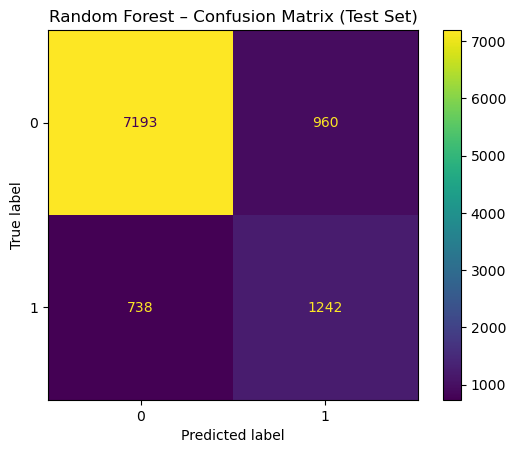

In [17]:
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format="d")
plt.title("Random Forest – Confusion Matrix (Test Set)")
plt.show()

In [18]:
# Get one-hot feature names
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([np.array(num_cols), cat_feature_names])

importances = best_model.named_steps["model"].feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fi.head(20)

outcome_previous_campaign_success            0.145421
current_balance                              0.113360
last_contact_unknown                         0.090620
last_contact_this_campaign_day               0.090574
age                                          0.089507
days_since_last_contact_previous_campaign    0.049713
this_campaign                                0.040525
housing_yes                                  0.038181
last_contact_cellular                        0.028923
housing_no                                   0.022832
last_contact_this_campaign_month_aug         0.022318
last_contact_this_campaign_month_jul         0.017481
conn_tr                                      0.016506
last_contact_this_campaign_month_nov         0.016445
contacted_during_previous_campaign           0.016182
last_contact_this_campaign_month_jun         0.015035
last_contact_this_campaign_month_apr         0.013949
last_contact_this_campaign_month_mar         0.012299
last_contact_this_campaign_m

In [19]:
search.best_score_


np.float64(0.8292105549277133)

In [20]:
search.best_params_

{'model__n_estimators': 400,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 16,
 'model__max_samples': 1.0,
 'model__max_features': 0.5,
 'model__max_depth': 16,
 'model__bootstrap': True}